Housekeeping

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.optimize import fsolve
import itertools

from f_detrend import detrend_fuction

sn.set_style('whitegrid')
%matplotlib inline
%load_ext autoreload
%autoreload 2

Auxiliary functions

In [2]:
# Expanded and modified version (first column now string)
def read_table(filename,keyword='ciclo',rescale=1,ncols=5,start=2,end_row='Total',
               endword=None,omit_list=['t20_21'],index_to_int=True,debug=False):
    t0 = start
    t1 = ncols+start
    results_follow = 0
    row_names = []
    interaction = 0
    f = open(filename,'r')
    for line in f:
        words = line.split()
        if debug:
            print(words)
        if len(words)>1 and words[0] == keyword:
            results_follow=1
            if endword==None:
                colnames = words[t0:t1]
            else:
                buff_v = []
                for w in words[t0:]:
                    if w==endword:
                        break
                    else:
                        buff_v.append(w)
                colnames = buff_v[:-1]
                t1 = len(buff_v)+t0-1
            table_raw = np.empty(t1-t0)
        elif len(words)>1 and words[0] == end_row:
            break
        elif len(words) == 1:
            interaction = 0
            i_count = 0
        elif len(words)>1 and results_follow==1: # and words[0] not in omit_list
            if len(words)==2 and words[1]=="|":
                var_name = words[0]
                interaction = 1
                i_count = 0
            else:
                if interaction==0:
                    row_names.append(words[0])
                else:
                    row_names.append(var_name+"_"+words[0])                        
                
                if words[2]=='|':
                    t00= t0+1
                    t11 = t1+1
                else:
                    t00 = t0
                    t11 = t1

                buff_v = []
                for w in words[t00:t11]: 
                    w = w.replace(",","")
                    buff_v.append(w)
                table_raw = np.vstack((table_raw,np.array(buff_v,dtype=float)/rescale))
    table_raw = table_raw[1:,:]
    if debug:
        print(table_raw.shape)
        print(colnames)
    if index_to_int:
        return pd.DataFrame(table_raw, columns=colnames,index=np.array(row_names,dtype=int))
    else:
        return pd.DataFrame(table_raw, columns=colnames,index=np.array(row_names))
    
    
def read_descriptive_stats(filename,keyword_data,keyword_col,ncols,rownames,start=2,debug=False):
    t0 = start
    t1 = ncols+start
    table_raw = np.empty(t1-t0)
    f = open(filename,'r')
    for line in f:
        words = line.split()
        if debug:
            print(words)
        if len(words)>1 and words[0] == keyword_data:
            buff_v = []
            for w in words[t0:t1]: 
                w = w.replace(",","")
                buff_v.append(w)
            table_raw = np.vstack((table_raw,np.array(buff_v,dtype=float)))
        elif len(words)>1 and words[0] == keyword_col:
            colnames = words[t0:t1]

    return pd.DataFrame(table_raw[1:,:], columns=colnames, index=rownames)
 
    
def file_split(filename,path,startwords=['Summary',],endword="Total",header=None):
    f = open(path+filename,'r')
    parent_file = filename[:filename.find('.')]
    di = 1
    writing = 0
    for line in f:
        words = line.split()
        if len(words)>0 and words[0] in startwords:
            sf = open(path+parent_file+'_{}.log'.format(di), "w")
            writing = 1
            if header!=None:
                sf.write(header)
        elif len(words)>0 and words[0]==endword and writing:
            sf.write(line)
            writing = 0
            sf.close()
            di+=1
        if writing:
            sf.write(line)
            
def normalise_table(table):
    cols = table.columns
    table['Total'] = table.sum(axis=1).copy()
    for col in cols:
        table[col] = table[col]/table['Total']
    return table   

Date dictionaries

In [3]:
dates = []
for year in range(1987,2022):
    for quarter in range(1,5):
        dates.append(str(year)+"Q"+str(quarter))
dates = dates[1:]

t0 = 59
t05 = 71
T = len(dates)
date_dict = dict(zip(range(t0,T+t0),dates))
date_dict_reverse = dict(zip(dates,range(0,T)))
date_dict_reverse_ciclo = dict(zip(dates,range(t0,T+t0)))

time_periods_thin = []
for y in range(2006,2022):
    time_periods_thin.append(str(y))
    
time_periods = ["t08_11", "t11_14", "t14_17", "t17_20", "t20","t21"]
period_labels = ['2008-2011','2011-2014','2014-2017','2017-2020','2020','2021']
    
def rename_interaction(tab,int_subs):
    tab_chunk_1 = tab.iloc[0:7].copy()
    tab_chunk_2 = tab.iloc[7:].copy()
    tab_chunk_1.rename(index=int_subs,inplace=True)
    tab = pd.concat((tab_chunk_1,tab_chunk_2))
    return tab

In [5]:
path = './results/'
ten_dist_moms = read_descriptive_stats(path+'descriptive_stats_tenure_mothers_all.log',
                       keyword_data='hub_ten_y',keyword_col='Variable',ncols=5,
                       rownames=[0,25,50,75],start=2,debug=False)
ten_dist_nomoms = read_descriptive_stats(path+'descriptive_stats_tenure_mothers_all_0k.log',
                       keyword_data='hub_ten_y',keyword_col='Variable',ncols=5,
                       rownames=[0,25,50,75],start=2,debug=False)

ten_dist_dads = read_descriptive_stats(path+'descriptive_stats_tenure_fathers_all.log',
                       keyword_data='wife_ten_y',keyword_col='Variable',ncols=5,
                       rownames=[0,25,50,75],start=2,debug=False)
ten_dist_nodads = read_descriptive_stats(path+'descriptive_stats_tenure_fathers_all_0k.log',
                       keyword_data='wife_ten_y',keyword_col='Variable',ncols=5,
                       rownames=[0,25,50,75],start=2,debug=False)

<a id='index'></a>


# Quantile regressions for tenure: coefficients by year

### Women, 35-45

Jump to
 - [Women 30-35](#women_3035)
 - [Men <45](#urgh)
 - [Men 30-35](#urgh_3035)
 
 
  - [Employment regresssions](#employment)
 
 
 - [Women, extensive margin, 30-35](#women_ext_3035)
 --------------
 Split result tables
 --------------
 Split result tables

In [8]:
path = './results/'
omits = ['sexo1#c.ttrend','sexo1#c.ttrend2',"covid#sexo1"]
# int_subs ={}
# for t in time_periods:
#     int_subs[t] = 'ten_'+t[1:]
name = "sqtreg_3035_hemp_time_int_diff_simple"
file_split('{}.log'.format(name),path,startwords=['q25','q50','q75'],endword="_cons",
           header="ten_y | Coefficient std t p_stat lower_95 upper_95")

tab_moms_45_25 = read_table(path+'{}_1.log'.format(name),
                         keyword='ten_y',rescale=1,ncols=6,start=2,omit_list=omits,index_to_int=False)
tab_moms_45_50 = read_table(path+'{}_2.log'.format(name),
                         keyword='ten_y',rescale=1,ncols=6,start=2,omit_list=omits,index_to_int=False)
tab_moms_45_75 = read_table(path+'{}_3.log'.format(name),
                         keyword='ten_y',rescale=1,ncols=6,start=2,omit_list=omits,index_to_int=False)

name = "sqtreg_3035_hemp_time_int_diff_simple_0k"
file_split('{}.log'.format(name),path,startwords=['q25','q50','q75'],endword="_cons",
           header="ten_y | Coefficient std t p_stat lower_95 upper_95")

tab_moms_45_25_0k = read_table(path+'{}_1.log'.format(name),
                         keyword='ten_y',rescale=1,ncols=6,start=2,omit_list=omits,index_to_int=False)
tab_moms_45_50_0k = read_table(path+'{}_2.log'.format(name),
                         keyword='ten_y',rescale=1,ncols=6,start=2,omit_list=omits,index_to_int=False)
tab_moms_45_75_0k = read_table(path+'{}_3.log'.format(name),
                         keyword='ten_y',rescale=1,ncols=6,start=2,omit_list=omits,index_to_int=False)


In [9]:
tab_moms_45_75

,Coefficient,std,t,p_stat,lower_95,upper_95q75
other_ten_y,0.169700,0.005253,32.31,0.000,0.159405,0.179996
ttrend,0.015127,0.008405,1.80,0.072,-0.001346,0.031600
ttrend2,0.000230,0.000166,1.39,0.164,-0.000094,0.000555
sexo1#c.ttrend_1,0.033960,0.014005,2.42,0.015,0.006510,0.061410
sexo1#c.ttrend2_1,-0.000447,0.000260,-1.72,0.086,-0.000956,0.000063
covid_1,-0.641774,0.305999,-2.10,0.036,-1.241529,-0.042019
covid_2,-0.207204,0.536677,-0.39,0.699,-1.259085,0.844677
1.sexo1,-1.298316,0.175656,-7.39,0.000,-1.642600,-0.954032
covid#sexo1_1,0.204451,0.396097,0.52,0.606,-0.571895,0.980796
covid#sexo1_2,-0.971496,0.592703,-1.64,0.101,-2.133186,0.190194


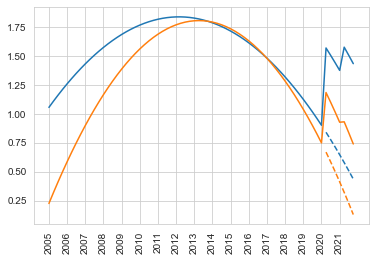

In [13]:
t_range = np.arange(0,68) # adjust this for your trend values!!
T = t_range.size
Tcovid1 = 61  # adjust this for your trend values!!
Tcovid2 = 65  # adjust this for your trend values!!
colors = sn.color_palette()
clab = 'Coefficient'
date_range = np.arange(2005,2022)

average_partner_tenure_for_this_quantile = (ten_dist_moms['p25'][25]+ten_dist_dads['p25'][25])/2

predict_dads = tab_moms_45_25[clab]['_cons']+tab_moms_45_25[clab]['ttrend']*t_range+ \
                tab_moms_45_25[clab]['ttrend2']*t_range**2 + \
                tab_moms_45_25[clab]['other_ten_y']*average_partner_tenure_for_this_quantile
predict_moms = predict_dads + tab_moms_45_25[clab]['sexo1#c.ttrend_1']*t_range+ \
                tab_moms_45_25[clab]['sexo1#c.ttrend2_1']*t_range**2 + \
                tab_moms_45_25[clab]['1.sexo1']
predict_dads_covid1 = predict_dads[Tcovid1:Tcovid2] + tab_moms_45_25[clab]['covid_1']
predict_dads_covid2 = predict_dads[Tcovid2:] + tab_moms_45_25[clab]['covid_2']
predict_dads_covid = np.hstack((predict_dads_covid1,predict_dads_covid2))

predict_moms_covid1 = predict_moms[Tcovid1:Tcovid2] + tab_moms_45_25[clab]['covid_1']+\
                                                        tab_moms_45_25[clab]['covid#sexo1_1']
predict_moms_covid2 = predict_moms[Tcovid2:] + tab_moms_45_25[clab]['covid_2']+\
                                                        tab_moms_45_25[clab]['covid#sexo1_2']
predict_moms_covid = np.hstack((predict_moms_covid1,predict_moms_covid2))

plt.plot(t_range, np.hstack((predict_dads[:Tcovid1],predict_dads_covid)))
# plt.plot(t_range[Tcovid:], predict_dads_covid,c=colors[0])
plt.plot(t_range[Tcovid1:], predict_dads[Tcovid1:],ls='--',c=colors[0])
plt.plot(t_range, np.hstack((predict_moms[:Tcovid1],predict_moms_covid)))
plt.plot(t_range[Tcovid1:], predict_moms[Tcovid1:],ls='--',c=colors[1])
plt.xticks(t_range[::4],date_range,rotation=90)
plt.show()

In [11]:
predict_moms_covid, predict_moms[-6:]

(array([1.18372664, 1.10115774, 1.01569084, 0.92732594, 0.93089314,
        0.83673224, 0.73967334]),
 array([0.58675144, 0.50128454, 0.41291964, 0.32165674, 0.22749584,
        0.13043694]))

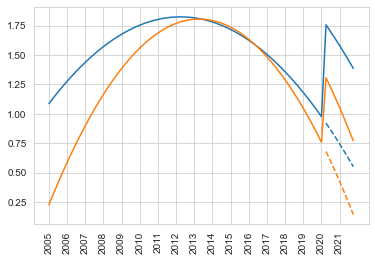

In [77]:
t_range = np.arange(0,68) # adjust this for your trend values!!
T = t_range.size
Tcovid = 61  # adjust this for your trend values!!
colors = sn.color_palette()

date_range = np.arange(2005,2022)

average_partner_tenure_for_this_quantile = (ten_dist_moms['p25'][25]+ten_dist_dads['p25'][25])/2

predict_dads = tab_moms_45_25['Coefficient']['_cons']+tab_moms_45_25['Coefficient']['ttrend']*t_range+ \
                tab_moms_45_25['Coefficient']['ttrend2']*t_range**2 + \
                tab_moms_45_25['Coefficient']['other_ten_y']*average_partner_tenure_for_this_quantile
predict_moms = predict_dads + tab_moms_45_25['Coefficient']['sexo1#c.ttrend_1']*t_range+ \
                tab_moms_45_25['Coefficient']['sexo1#c.ttrend2_1']*t_range**2 + \
                tab_moms_45_25['Coefficient']['1.sexo1']
predict_dads_covid = predict_dads[Tcovid:] + tab_moms_45_25['Coefficient']['1.covid']
predict_moms_covid = predict_moms[Tcovid:] + tab_moms_45_25['Coefficient']['1.covid']+ \
                    tab_moms_45_25['Coefficient']['covid#sexo1_1']

plt.plot(t_range, np.hstack((predict_dads[:Tcovid],predict_dads_covid)))
# plt.plot(t_range[Tcovid:], predict_dads_covid,c=colors[0])
plt.plot(t_range[Tcovid:], predict_dads[Tcovid:],ls='--',c=colors[0])
plt.plot(t_range, np.hstack((predict_moms[:Tcovid],predict_moms_covid)))
plt.plot(t_range[Tcovid:], predict_moms[Tcovid:],ls='--',c=colors[1])
plt.xticks(t_range[::4],date_range,rotation=90)
plt.show()

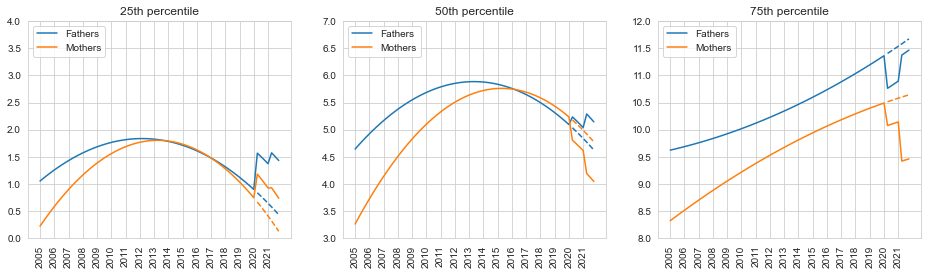

In [14]:
t_range = np.arange(0,68) # adjust this for your trend values!!
T = t_range.size
Tcovid = 61  # adjust this for your trend values!!
colors = sn.color_palette()
clab = 'Coefficient'
ylims = ((0,4),(3,7),(8,12))

date_range = np.arange(2005,2022)

all_tabs = dict(zip([25,50,75],[tab_moms_45_25,tab_moms_45_50,tab_moms_45_75]))

plt.figure(figsize=(16,4))
for iq,q in enumerate(all_tabs.keys()):   

    av_partner_tenure_for_this_quant = (ten_dist_moms['p{}'.format(q)][q]+ten_dist_dads['p{}'.format(q)][q])/2

    predict_dads = all_tabs[q][clab]['_cons']+all_tabs[q][clab]['ttrend']*t_range+ \
                    all_tabs[q][clab]['ttrend2']*t_range**2 + \
                    all_tabs[q][clab]['other_ten_y']*av_partner_tenure_for_this_quant
    predict_moms = predict_dads + all_tabs[q][clab]['sexo1#c.ttrend_1']*t_range+ \
                    all_tabs[q][clab]['sexo1#c.ttrend2_1']*t_range**2 + \
                    all_tabs[q][clab]['1.sexo1']
    
    predict_dads_covid1 = predict_dads[Tcovid1:Tcovid2] + all_tabs[q][clab]['covid_1']
    predict_dads_covid2 = predict_dads[Tcovid2:] + all_tabs[q][clab]['covid_2']
    predict_dads_covid = np.hstack((predict_dads_covid1,predict_dads_covid2))

    predict_moms_covid1 = predict_moms[Tcovid1:Tcovid2] + all_tabs[q][clab]['covid_1']+\
                                                            all_tabs[q][clab]['covid#sexo1_1']
    predict_moms_covid2 = predict_moms[Tcovid2:] + all_tabs[q][clab]['covid_2']+\
                                                            all_tabs[q][clab]['covid#sexo1_2']
    predict_moms_covid = np.hstack((predict_moms_covid1,predict_moms_covid2))
    
    plt.subplot(131+iq)
    plt.title('{}th percentile'.format(q))
    plt.plot(t_range, np.hstack((predict_dads[:Tcovid],predict_dads_covid)),label='Fathers')
    plt.plot(t_range[Tcovid:], predict_dads[Tcovid:],ls='--',c=colors[0])
    plt.plot(t_range, np.hstack((predict_moms[:Tcovid],predict_moms_covid)),label='Mothers')
    plt.plot(t_range[Tcovid:], predict_moms[Tcovid:],ls='--',c=colors[1])
    plt.legend(loc=2)
#     plt.axvline(Tcovid,c='r',lw=0.5)
    plt.ylim(ylims[iq])
    plt.xticks(t_range[::4],date_range,rotation=90)
plt.show()

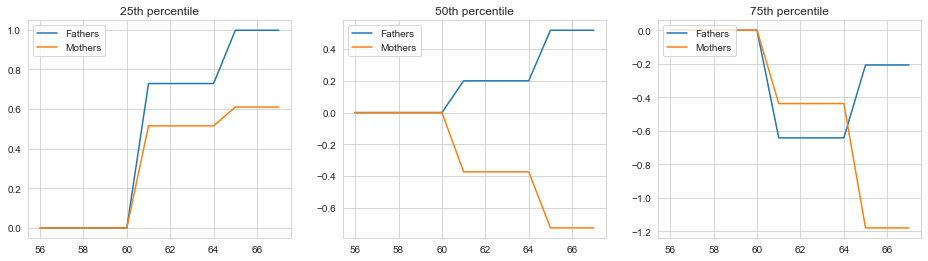

In [15]:
t_range = np.arange(0,68) # adjust this for your trend values!!
T = t_range.size
Tcovid = 61  # adjust this for your trend values!!
colors = sn.color_palette()
clab = 'Coefficient'
ylims = ((0,4),(3,7),(8,12))

date_range = np.arange(2005,2022)

all_tabs = dict(zip([25,50,75],[tab_moms_45_25,tab_moms_45_50,tab_moms_45_75]))

plt.figure(figsize=(16,4))
for iq,q in enumerate(all_tabs.keys()):  
    
    av_partner_tenure_for_this_quant = (ten_dist_moms['p{}'.format(q)][q]+ten_dist_dads['p{}'.format(q)][q])/2

    predict_dads = all_tabs[q][clab]['_cons']+all_tabs[q][clab]['ttrend']*t_range+ \
                    all_tabs[q][clab]['ttrend2']*t_range**2 + \
                    all_tabs[q][clab]['other_ten_y']*av_partner_tenure_for_this_quant
    predict_moms = predict_dads + all_tabs[q][clab]['sexo1#c.ttrend_1']*t_range+ \
                    all_tabs[q][clab]['sexo1#c.ttrend2_1']*t_range**2 + \
                    all_tabs[q][clab]['1.sexo1']
    predict_dads_covid1 = predict_dads[Tcovid1:Tcovid2] + all_tabs[q][clab]['covid_1']
    predict_dads_covid2 = predict_dads[Tcovid2:] + all_tabs[q][clab]['covid_2']
    predict_dads_covid = np.hstack((predict_dads_covid1,predict_dads_covid2))

    predict_moms_covid1 = predict_moms[Tcovid1:Tcovid2] + all_tabs[q][clab]['covid_1']+\
                                                            all_tabs[q][clab]['covid#sexo1_1']
    predict_moms_covid2 = predict_moms[Tcovid2:] + all_tabs[q][clab]['covid_2']+\
                                                            all_tabs[q][clab]['covid#sexo1_2']
    predict_moms_covid = np.hstack((predict_moms_covid1,predict_moms_covid2))

    trend_devs_dads = np.hstack((predict_dads[:Tcovid],predict_dads_covid)) - predict_dads
    trend_devs_moms = np.hstack((predict_moms[:Tcovid],predict_moms_covid)) - predict_moms
    
    plt.subplot(131+iq)
    plt.title('{}th percentile'.format(q))
    plt.plot(t_range[-12:],trend_devs_dads[-12:],label='Fathers')
    plt.plot(t_range[-12:],trend_devs_moms[-12:],label='Mothers')
    plt.legend(loc=2)
#     plt.axvline(Tcovid,c='r',lw=0.5)
#     plt.ylim(ylims[iq])
#     plt.xticks(t_range[-6::4],date_range,rotation=90)
plt.show()

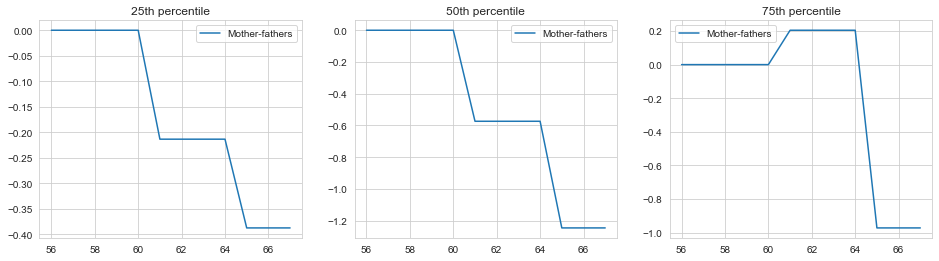

In [138]:
t_range = np.arange(0,68) # adjust this for your trend values!!
T = t_range.size
Tcovid = 61  # adjust this for your trend values!!
colors = sn.color_palette()
clab = 'Coefficient'
ylims = ((0,4),(3,7),(8,12))

DiD_children = {}

date_range = np.arange(2005,2022)

all_tabs = dict(zip([25,50,75],[tab_moms_45_25,tab_moms_45_50,tab_moms_45_75]))

plt.figure(figsize=(16,4))
for iq,q in enumerate(all_tabs.keys()):  
    
    av_partner_tenure_for_this_quant = (ten_dist_moms['p{}'.format(q)][q]+ten_dist_dads['p{}'.format(q)][q])/2

    predict_dads = all_tabs[q][clab]['_cons']+all_tabs[q][clab]['ttrend']*t_range+ \
                    all_tabs[q][clab]['ttrend2']*t_range**2 + \
                    all_tabs[q][clab]['other_ten_y']*av_partner_tenure_for_this_quant
    predict_moms = predict_dads + all_tabs[q][clab]['sexo1#c.ttrend_1']*t_range+ \
                    all_tabs[q][clab]['sexo1#c.ttrend2_1']*t_range**2 + \
                    all_tabs[q][clab]['1.sexo1']
    predict_dads_covid1 = predict_dads[Tcovid1:Tcovid2] + all_tabs[q][clab]['covid_1']
    predict_dads_covid2 = predict_dads[Tcovid2:] + all_tabs[q][clab]['covid_2']
    predict_dads_covid = np.hstack((predict_dads_covid1,predict_dads_covid2))

    predict_moms_covid1 = predict_moms[Tcovid1:Tcovid2] + all_tabs[q][clab]['covid_1']+\
                                                            all_tabs[q][clab]['covid#sexo1_1']
    predict_moms_covid2 = predict_moms[Tcovid2:] + all_tabs[q][clab]['covid_2']+\
                                                            all_tabs[q][clab]['covid#sexo1_2']
    predict_moms_covid = np.hstack((predict_moms_covid1,predict_moms_covid2))

    trend_devs_dads = np.hstack((predict_dads[:Tcovid],predict_dads_covid)) - predict_dads
    trend_devs_moms = np.hstack((predict_moms[:Tcovid],predict_moms_covid)) - predict_moms
    
    DiD_children[q] = trend_devs_moms-trend_devs_dads
    
    plt.subplot(131+iq)
    plt.title('{}th percentile'.format(q))
    plt.plot(t_range[-12:],trend_devs_moms[-12:]-trend_devs_dads[-12:],label='Mother-fathers')
    plt.legend(loc='best')
#     plt.axvline(Tcovid,c='r',lw=0.5)
#     plt.ylim(ylims[iq])
#     plt.xticks(t_range[-6::4],date_range,rotation=90)
plt.show()

No children

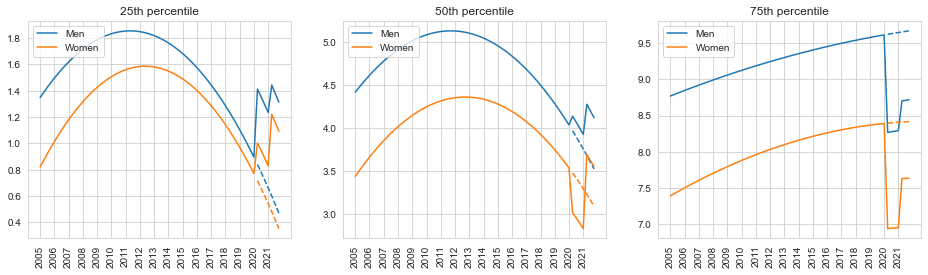

In [130]:
t_range = np.arange(0,68) # adjust this for your trend values!!
T = t_range.size
Tcovid = 61  # adjust this for your trend values!!
colors = sn.color_palette()
clab = 'Coefficient'
ylims = ((0,4),(3,7),(8,12))

date_range = np.arange(2005,2022)

all_tabs = dict(zip([25,50,75],[tab_moms_45_25_0k,tab_moms_45_50_0k,tab_moms_45_75_0k]))

plt.figure(figsize=(16,4))
for iq,q in enumerate(all_tabs.keys()):   

    av_partner_tenure_for_this_quant = (ten_dist_nomoms['p{}'.format(q)][q]+ten_dist_nodads['p{}'.format(q)][q])/2

    predict_dads = all_tabs[q][clab]['_cons']+all_tabs[q][clab]['ttrend']*t_range+ \
                    all_tabs[q][clab]['ttrend2']*t_range**2 + \
                    all_tabs[q][clab]['other_ten_y']*av_partner_tenure_for_this_quant
    predict_moms = predict_dads + all_tabs[q][clab]['sexo1#c.ttrend_1']*t_range+ \
                    all_tabs[q][clab]['sexo1#c.ttrend2_1']*t_range**2 + \
                    all_tabs[q][clab]['1.sexo1']
    
    predict_dads_covid1 = predict_dads[Tcovid1:Tcovid2] + all_tabs[q][clab]['covid_1']
    predict_dads_covid2 = predict_dads[Tcovid2:] + all_tabs[q][clab]['covid_2']
    predict_dads_covid = np.hstack((predict_dads_covid1,predict_dads_covid2))

    predict_moms_covid1 = predict_moms[Tcovid1:Tcovid2] + all_tabs[q][clab]['covid_1']+\
                                                            all_tabs[q][clab]['covid#sexo1_1']
    predict_moms_covid2 = predict_moms[Tcovid2:] + all_tabs[q][clab]['covid_2']+\
                                                            all_tabs[q][clab]['covid#sexo1_2']
    predict_moms_covid = np.hstack((predict_moms_covid1,predict_moms_covid2))
    
    plt.subplot(131+iq)
    plt.title('{}th percentile'.format(q))
    plt.plot(t_range, np.hstack((predict_dads[:Tcovid],predict_dads_covid)),label='Men')
    plt.plot(t_range[Tcovid:], predict_dads[Tcovid:],ls='--',c=colors[0])
    plt.plot(t_range, np.hstack((predict_moms[:Tcovid],predict_moms_covid)),label='Women')
    plt.plot(t_range[Tcovid:], predict_moms[Tcovid:],ls='--',c=colors[1])
    plt.legend(loc=2)
#     plt.axvline(Tcovid,c='r',lw=0.5)
#     plt.ylim(ylims[iq])
    plt.xticks(t_range[::4],date_range,rotation=90)
plt.show()

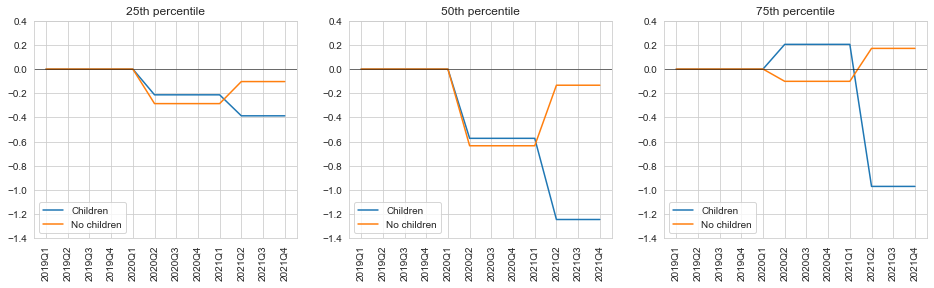

In [147]:
t_range = np.arange(0,68) # adjust this for your trend values!!
T = t_range.size
Tcovid = 61  # adjust this for your trend values!!
colors = sn.color_palette()
clab = 'Coefficient'
ylims = ((0,4),(3,7),(8,12))

date_range = np.arange(2005,2022)

all_tabs = dict(zip([25,50,75],[tab_moms_45_25_0k,tab_moms_45_50_0k,tab_moms_45_75_0k]))

plt.figure(figsize=(16,4))
for iq,q in enumerate(all_tabs.keys()):  
    
    av_partner_tenure_for_this_quant = (ten_dist_nomoms['p{}'.format(q)][q]+ten_dist_nodads['p{}'.format(q)][q])/2

    predict_nodads = all_tabs[q][clab]['_cons']+all_tabs[q][clab]['ttrend']*t_range+ \
                    all_tabs[q][clab]['ttrend2']*t_range**2 + \
                    all_tabs[q][clab]['other_ten_y']*av_partner_tenure_for_this_quant
    predict_nomoms = predict_nodads + all_tabs[q][clab]['sexo1#c.ttrend_1']*t_range+ \
                    all_tabs[q][clab]['sexo1#c.ttrend2_1']*t_range**2 + \
                    all_tabs[q][clab]['1.sexo1']
    predict_nodads_covid1 = predict_nodads[Tcovid1:Tcovid2] + all_tabs[q][clab]['covid_1']
    predict_nodads_covid2 = predict_nodads[Tcovid2:] + all_tabs[q][clab]['covid_2']
    predict_nodads_covid = np.hstack((predict_nodads_covid1,predict_nodads_covid2))

    predict_nomoms_covid1 = predict_nomoms[Tcovid1:Tcovid2] + all_tabs[q][clab]['covid_1']+\
                                                            all_tabs[q][clab]['covid#sexo1_1']
    predict_nomoms_covid2 = predict_nomoms[Tcovid2:] + all_tabs[q][clab]['covid_2']+\
                                                            all_tabs[q][clab]['covid#sexo1_2']
    predict_nomoms_covid = np.hstack((predict_nomoms_covid1,predict_nomoms_covid2))

    trend_devs_nodads = np.hstack((predict_nodads[:Tcovid],predict_nodads_covid)) - predict_nodads
    trend_devs_nomoms = np.hstack((predict_nomoms[:Tcovid],predict_nomoms_covid)) - predict_nomoms
    
    plt.subplot(131+iq)
    plt.title('{}th percentile'.format(q))
    plt.plot(t_range[-12:],DiD_children[q][-12:],label='Children')
    plt.plot(t_range[-12:],trend_devs_nomoms[-12:]-trend_devs_nodads[-12:],label='No children')
    plt.legend(loc=3)
    plt.axhline(0,c='k',lw=0.5)
    plt.ylim(-1.4,0.4)
    plt.xticks(t_range[-12:],dates[-12:],rotation=90)
plt.show()

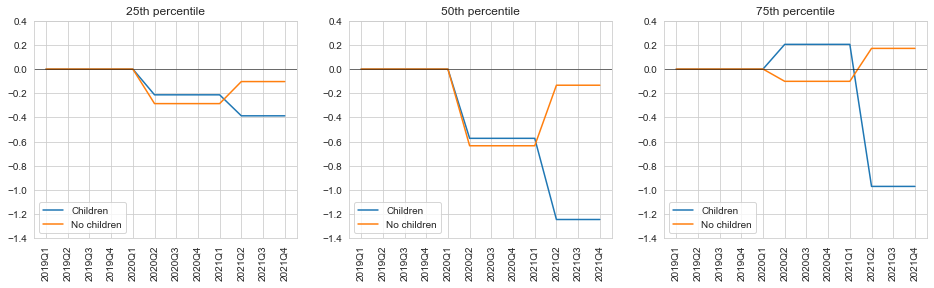

In [147]:
t_range = np.arange(0,68) # adjust this for your trend values!!
T = t_range.size
Tcovid = 61  # adjust this for your trend values!!
colors = sn.color_palette()
clab = 'Coefficient'
ylims = ((0,4),(3,7),(8,12))

date_range = np.arange(2005,2022)

all_tabs = dict(zip([25,50,75],[tab_moms_45_25_0k,tab_moms_45_50_0k,tab_moms_45_75_0k]))

plt.figure(figsize=(16,4))
for iq,q in enumerate(all_tabs.keys()):  
    
    av_partner_tenure_for_this_quant = (ten_dist_nomoms['p{}'.format(q)][q]+ten_dist_nodads['p{}'.format(q)][q])/2

    predict_nodads = all_tabs[q][clab]['_cons']+all_tabs[q][clab]['ttrend']*t_range+ \
                    all_tabs[q][clab]['ttrend2']*t_range**2 + \
                    all_tabs[q][clab]['other_ten_y']*av_partner_tenure_for_this_quant
    predict_nomoms = predict_nodads + all_tabs[q][clab]['sexo1#c.ttrend_1']*t_range+ \
                    all_tabs[q][clab]['sexo1#c.ttrend2_1']*t_range**2 + \
                    all_tabs[q][clab]['1.sexo1']
    predict_nodads_covid1 = predict_nodads[Tcovid1:Tcovid2] + all_tabs[q][clab]['covid_1']
    predict_nodads_covid2 = predict_nodads[Tcovid2:] + all_tabs[q][clab]['covid_2']
    predict_nodads_covid = np.hstack((predict_nodads_covid1,predict_nodads_covid2))

    predict_nomoms_covid1 = predict_nomoms[Tcovid1:Tcovid2] + all_tabs[q][clab]['covid_1']+\
                                                            all_tabs[q][clab]['covid#sexo1_1']
    predict_nomoms_covid2 = predict_nomoms[Tcovid2:] + all_tabs[q][clab]['covid_2']+\
                                                            all_tabs[q][clab]['covid#sexo1_2']
    predict_nomoms_covid = np.hstack((predict_nomoms_covid1,predict_nomoms_covid2))

    trend_devs_nodads = np.hstack((predict_nodads[:Tcovid],predict_nodads_covid)) - predict_nodads
    trend_devs_nomoms = np.hstack((predict_nomoms[:Tcovid],predict_nomoms_covid)) - predict_nomoms
    
    plt.subplot(131+iq)
    plt.title('{}th percentile'.format(q))
    plt.plot(t_range[-12:],DiD_children[q][-12:],label='Children')
    plt.plot(t_range[-12:],trend_devs_nomoms[-12:]-trend_devs_nodads[-12:],label='No children')
    plt.legend(loc=3)
    plt.axhline(0,c='k',lw=0.5)
    plt.ylim(-1.4,0.4)
    plt.xticks(t_range[-12:],dates[-12:],rotation=90)
plt.show()

## Just plot the coefficients

In [149]:
tab_moms_45_25

,Coefficient,std,t,p_stat,lower_95,upper_95q25
other_ten_y,0.103145,0.003079,33.50,0.000,0.097109,0.109180
ttrend,0.054563,0.006062,9.00,0.000,0.042683,0.066443
ttrend2,-0.000952,0.000107,-8.94,0.000,-0.001161,-0.000743
sexo1#c.ttrend_1,0.041095,0.008721,4.71,0.000,0.024002,0.058188
sexo1#c.ttrend2_1,-0.000497,0.000150,-3.32,0.001,-0.000790,-0.000203
covid_1,0.727755,0.132293,5.50,0.000,0.468462,0.987048
covid_2,0.996369,0.234292,4.25,0.000,0.537160,1.455578
1.sexo1,-0.829443,0.086997,-9.53,0.000,-0.999955,-0.658931
covid#sexo1_1,-0.213349,0.188784,-1.13,0.258,-0.583364,0.156666
covid#sexo1_2,-0.387133,0.260800,-1.48,0.138,-0.898298,0.124032


In [17]:
coeffs_period_children = {}
coeffs_period_nochildren = {}

upper_children,lower_children = {}, {}
upper_nochildren,lower_nochildren = {}, {}

clab = 'Coefficient'
lowerlab= "lower_95"
upperlab = "upper_95q"
all_tabs = dict(zip([25,50,75],[tab_moms_45_25,tab_moms_45_50,tab_moms_45_75]))
all_tabs_0k = dict(zip([25,50,75],[tab_moms_45_25_0k,tab_moms_45_50_0k,tab_moms_45_75_0k]))

for q in [25,50,75]:
    coef_b0 = all_tabs[q][clab]['covid#sexo1_1']
    coef_b1 = all_tabs[q][clab]['covid#sexo1_2']
    coeffs_period_children[q] = np.hstack((coef_b0,coef_b1))
    
    coef_b0 = all_tabs_0k[q][clab]['covid#sexo1_1']
    coef_b1 = all_tabs_0k[q][clab]['covid#sexo1_2']
    coeffs_period_nochildren[q] = np.hstack((coef_b0,coef_b1))    
        
    upper_children[q] = (all_tabs[q][upperlab+str(q)]['covid#sexo1_1'],all_tabs[q][upperlab+str(q)]['covid#sexo1_2'])
    lower_children[q] = (all_tabs[q][lowerlab]['covid#sexo1_1'],all_tabs[q][lowerlab]['covid#sexo1_2']) 
    
    upper_nochildren[q] = (all_tabs_0k[q][upperlab+str(q)]['covid#sexo1_1'],
                           all_tabs_0k[q][upperlab+str(q)]['covid#sexo1_2'])
    lower_nochildren[q] = (all_tabs_0k[q][lowerlab]['covid#sexo1_1'],
                           all_tabs_0k[q][lowerlab]['covid#sexo1_2']) 


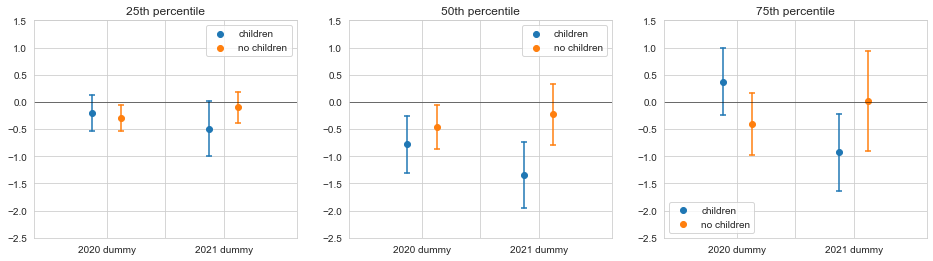

In [24]:
coeff_range = np.arange(len(coeffs_period_children.values()))
N = coeff_range.size
colors = sn.color_palette()
ylims = ((0,4),(3,7),(8,12))

date_range = np.arange(2005,2022)

all_tabs = dict(zip([25,50,75],[tab_moms_45_25,tab_moms_45_50,tab_moms_45_75]))
all_tabs_0k = dict(zip([25,50,75],[tab_moms_45_25_0k,tab_moms_45_50_0k,tab_moms_45_75_0k]))

sn.set_style('whitegrid')
plt.figure(figsize=(16,4))
for iq,q in enumerate(all_tabs.keys()):   
    
    plt.subplot(131+iq)
    plt.title('{}th percentile'.format(q))
    plt.scatter(np.arange(0,2),coeffs_period_children[q],marker='o',color=colors[0],label='children')
    plt.scatter(np.arange(0,2),upper_children[q],marker='_',color=colors[0])
    plt.scatter(np.arange(0,2),lower_children[q],marker='_',color=colors[0])
    plt.scatter(np.arange(0.25,2.25,1),coeffs_period_nochildren[q],marker='o',color=colors[1],label='no children')
    plt.scatter(np.arange(0.25,2.25,1),upper_nochildren[q],marker='_',color=colors[1])
    plt.scatter(np.arange(0.25,2.25,1),lower_nochildren[q],marker='_',color=colors[1])
    for i in range(2):
        plt.plot((i,i),(lower_children[q][i],upper_children[q][i]),c=colors[0])
        plt.plot(((0.25+i),(0.25+i)),(lower_nochildren[q][i],upper_nochildren[q][i]),c=colors[1])
    plt.axhline(c='k',lw=0.5)
    plt.ylim(-2.5,1.5)
    plt.xlim(-0.5,1.75)
    plt.legend()
    plt.xticks([0.125,0.625,1.125],['2020 dummy','','2021 dummy'])
#     plt.xlabel('2020 dummy                                    2021 dummy')
plt.savefig('./plots_tenure/coeffs_compare_simple.pdf',format='pdf',bbox_inches='tight')
plt.show()

## With controls

In [6]:
path = './results/'
omits = ['sexo1#c.ttrend','sexo1#c.ttrend2',"covid#sexo1"]
# int_subs ={}
# for t in time_periods:
#     int_subs[t] = 'ten_'+t[1:]
name = "sqtreg_3040_hemp_time_int_diff"
file_split('{}.log'.format(name),path,startwords=['q25','q50','q75'],endword="_cons",
           header="ten_y | Coefficient std t p_stat lower_95 upper_95")

tab_moms_45_25 = read_table(path+'{}_1.log'.format(name),
                         keyword='ten_y',rescale=1,ncols=6,start=2,omit_list=omits,index_to_int=False)
tab_moms_45_50 = read_table(path+'{}_2.log'.format(name),
                         keyword='ten_y',rescale=1,ncols=6,start=2,omit_list=omits,index_to_int=False)
tab_moms_45_75 = read_table(path+'{}_3.log'.format(name),
                         keyword='ten_y',rescale=1,ncols=6,start=2,omit_list=omits,index_to_int=False)

name = "sqtreg_3035_hemp_time_int_diff_0k"
file_split('{}.log'.format(name),path,startwords=['q25','q50','q75'],endword="_cons",
           header="ten_y | Coefficient std t p_stat lower_95 upper_95")

tab_moms_45_25_0k = read_table(path+'{}_1.log'.format(name),
                         keyword='ten_y',rescale=1,ncols=6,start=2,omit_list=omits,index_to_int=False)
tab_moms_45_50_0k = read_table(path+'{}_2.log'.format(name),
                         keyword='ten_y',rescale=1,ncols=6,start=2,omit_list=omits,index_to_int=False)
tab_moms_45_75_0k = read_table(path+'{}_3.log'.format(name),
                         keyword='ten_y',rescale=1,ncols=6,start=2,omit_list=omits,index_to_int=False)


FileNotFoundError: [Errno 2] No such file or directory: './results/sqtreg_3040_hemp_time_int_diff.log'

In [223]:
tab_moms_45_25

,Coefficient,std,t,p_stat,lower_95,upper_95q25
other_ten_y,0.080217,0.003413,23.50,0.000,0.073527,0.086907
ttrend,0.044030,0.006718,6.55,0.000,0.030864,0.057197
ttrend2,-0.000751,0.000106,-7.12,0.000,-0.000957,-0.000544
sexo1#c.ttrend_1,0.034543,0.007783,4.44,0.000,0.019289,0.049797
sexo1#c.ttrend2_1,-0.000443,0.000116,-3.81,0.000,-0.000670,-0.000215
covid_1,0.546773,0.141722,3.86,0.000,0.268999,0.824546
covid_2,0.937799,0.228697,4.10,0.000,0.489555,1.386042
1.sexo1,-0.630380,0.092123,-6.84,0.000,-0.810940,-0.449819
covid#sexo1_1,-0.210845,0.169524,-1.24,0.214,-0.543111,0.121421
covid#sexo1_2,-0.490860,0.260105,-1.89,0.059,-1.000662,0.018942


In [20]:
coeffs_children = {}
coeffs_nochildren = {}

upper_children,lower_children = {}, {}
upper_nochildren,lower_nochildren = {}, {}

clab = 'Coefficient'
lowerlab= "lower_95"
upperlab = "upper_95q"
all_tabs = dict(zip([25,50,75],[tab_moms_45_25,tab_moms_45_50,tab_moms_45_75]))
all_tabs_0k = dict(zip([25,50,75],[tab_moms_45_25_0k,tab_moms_45_50_0k,tab_moms_45_75_0k]))

for q in [25,50,75]:
    coef_b0 = all_tabs[q][clab]['covid#sexo1_1']
    coef_b1 = all_tabs[q][clab]['covid#sexo1_2']
    coeffs_period_children[q] = np.hstack((coef_b0,coef_b1))
    
    coef_b0 = all_tabs_0k[q][clab]['covid#sexo1_1']
    coef_b1 = all_tabs_0k[q][clab]['covid#sexo1_2']
    coeffs_period_nochildren[q] = np.hstack((coef_b0,coef_b1))    
        
    upper_children[q] = (all_tabs[q][upperlab+str(q)]['covid#sexo1_1'],all_tabs[q][upperlab+str(q)]['covid#sexo1_2'])
    lower_children[q] = (all_tabs[q][lowerlab]['covid#sexo1_1'],all_tabs[q][lowerlab]['covid#sexo1_2']) 
    
    upper_nochildren[q] = (all_tabs_0k[q][upperlab+str(q)]['covid#sexo1_1'],
                           all_tabs_0k[q][upperlab+str(q)]['covid#sexo1_2'])
    lower_nochildren[q] = (all_tabs_0k[q][lowerlab]['covid#sexo1_1'],
                           all_tabs_0k[q][lowerlab]['covid#sexo1_2']) 


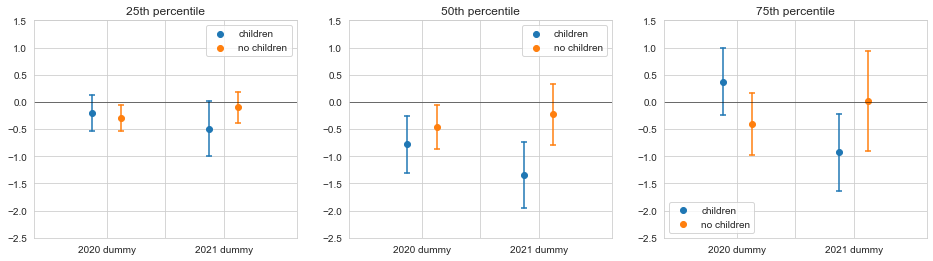

In [23]:
coeff_range = np.arange(len(coeffs_period_children.values()))
N = coeff_range.size
colors = sn.color_palette()
ylims = ((0,4),(3,7),(8,12))

date_range = np.arange(2005,2022)

all_tabs = dict(zip([25,50,75],[tab_moms_45_25,tab_moms_45_50,tab_moms_45_75]))
all_tabs_0k = dict(zip([25,50,75],[tab_moms_45_25_0k,tab_moms_45_50_0k,tab_moms_45_75_0k]))

sn.set_style('whitegrid')
plt.figure(figsize=(16,4))
for iq,q in enumerate(all_tabs.keys()):   
    
    plt.subplot(131+iq)
    plt.title('{}th percentile'.format(q))
    plt.scatter(np.arange(0,2),coeffs_period_children[q],marker='o',color=colors[0],label='children')
    plt.scatter(np.arange(0,2),upper_children[q],marker='_',color=colors[0])
    plt.scatter(np.arange(0,2),lower_children[q],marker='_',color=colors[0])
    plt.scatter(np.arange(0.25,2.25,1),coeffs_period_nochildren[q],marker='o',color=colors[1],label='no children')
    plt.scatter(np.arange(0.25,2.25,1),upper_nochildren[q],marker='_',color=colors[1])
    plt.scatter(np.arange(0.25,2.25,1),lower_nochildren[q],marker='_',color=colors[1])
    for i in range(2):
        plt.plot((i,i),(lower_children[q][i],upper_children[q][i]),c=colors[0])
        plt.plot(((0.25+i),(0.25+i)),(lower_nochildren[q][i],upper_nochildren[q][i]),c=colors[1])
#     plt.legend(loc=2)
    plt.axhline(c='k',lw=0.5)
    plt.ylim(-2.5,1.5)
    plt.xlim(-0.5,1.75)
    plt.legend()
    plt.xticks([0.125,0.625,1.125],['2020 dummy','','2021 dummy'])
#     plt.xlabel('2020 dummy                                    2021 dummy')
plt.savefig('./plots_tenure/coeffs_compare_controls.pdf',format='pdf',bbox_inches='tight')
plt.show()